# 1 Load Data

In [59]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [60]:

path = "../data/california-house-prices/"
train_data = pd.read_csv(path+'train.csv')
test_data = pd.read_csv(path+'test.csv')

# 2 数据清洗
在每个样本中，第一个特征是ID， 我们将其从数据集中删除
只提取特征，train_data的最后一列是label

In [61]:
all_features = pd.concat((train_data.iloc[:, 2:-1], test_data.iloc[:, 1:]))

all_features.shape
#前四个和最后两个特征，以及相应标签
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]


,Id,Address,Sold Price,Summary,City,Zip,State
0,0,540 Pine Ln,3825000.0,"540 Pine Ln, Los Altos, CA 94022 is a single f...",Los Altos,94022,CA
1,1,1727 W 67th St,505000.0,"HURRY, HURRY.......Great house 3 bed and 2 bat...",Los Angeles,90047,CA
2,2,28093 Pine Ave,140000.0,'THE PERFECT CABIN TO FLIP! Strawberry deligh...,Strawberry,95375,CA
3,3,10750 Braddock Dr,1775000.0,Rare 2-story Gated 5 bedroom Modern Mediterran...,Culver City,90230,CA


In [62]:
#获取数值型value的索引
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

# 最先只用有数字的特征
features = all_features[numeric_features].fillna(0)
features = features.iloc[:,1:].apply(
    lambda x: (x - x.mean()) / (x.std()))
train_labels = torch.tensor(features.iloc[:,1].values.reshape(-1, 1),
                            dtype=torch.float32)

features.shape,train_labels.shape



((79065, 18), torch.Size([79065, 1]))

In [63]:
#从pandas格式中提取NumPy格式，并将其转换为张量表示
## 训练样本数，numpy默认是float64
n_train = train_data.shape[0]
train_features = torch.tensor(features[:n_train].values,
                              dtype=torch.float32)
test_features = torch.tensor(features.iloc[n_train:].values,
                             dtype=torch.float32)




# 3 Models

In [64]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

In [65]:
#我们更关心相对误差(y−y_hat)/y， 解决这个问题的一种方法是用价格预测的对数(log)来衡量差异
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

# 4 Train
采用Adam，对lr没有那么敏感

In [66]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [67]:
#K折交叉验证
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        #第一次为空，记下来
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            #在dim=0，连接X_train
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

# 5 K-fold Training

In [68]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    #用来记录train和validate的损失
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        #传入的是一个元组
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        #累加append的最后一个元素
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    #返回avg_loss
    return train_l_sum / k, valid_l_sum / k

fold 1, train log rmse nan, valid log rmse nan
fold 2, train log rmse nan, valid log rmse nan
fold 3, train log rmse nan, valid log rmse nan
3-折验证: 平均训练log rmse: nan, 平均验证log rmse: nan


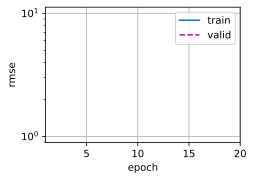

In [70]:
k, num_epochs, lr, weight_decay, batch_size = 3, 20,0.001, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')